In [28]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [29]:
EMBEDDING_DIM = 100 #will be used in the embedding layer of the model
MAXLEN = 16 #maximum length of all sequences
TRUNCATING = 'post' #truncate after each sequence
PADDING = 'post' #post-padding
OOV_TOKEN = "<OOV>" #token to replace out-of-vocabulary words during text_to_sequence calls
MAX_EXAMPLES = 160000 #max number of examples to use - 160000 (10% of the original number of examples)
TRAINING_SPLIT = 0.9

In [30]:
SENTIMENT_CSV = "./sentiment140/train.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First two data points look like this:\n\n{csvfile.readline()}\n\n{csvfile.readline()}")

First two data points look like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"


"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



In [31]:
#parsing the raw data
def parse_data_from_file(filename):
    
    sentences = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            labels.append(0 if row[0] == 0 else 1)
            sentences.append(row[5])
        
    return sentences, labels

In [32]:
# 10% of the original data will be used
sentences_and_labels = list(zip(sentences, labels))

# random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

sentences, labels = zip(*sentences_and_labels)

In [33]:
#training - validation split
def train_val_split(sentences, labels, training_split):

    train_size = int(training_split * len(sentences))

    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [34]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


In [35]:
#tokenization
def fit_tokenizer(train_sentences, oov_token):
    
    tokenizer = Tokenizer(oov_token = oov_token)
    
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [36]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

In [37]:
#truncating and padding
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    
    sequences = tokenizer.texts_to_sequences(sentences)
    
    pad_trunc_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding, truncating=truncating)
    
    return pad_trunc_sequences

In [38]:
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

In [39]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

## Using pre-defined Embeddings
100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford will be used.

In [41]:
GLOVE_FILE = './embeddings/glove.6B.100d.txt'

GLOVE_EMBEDDINGS = {}

with open(GLOVE_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [44]:
#testing for 'dog'
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(test_vector)

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.30569    0.31748    0.021404
  0.11837   -0.11319    

In [45]:
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# iterating all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

## Model

In [46]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
                  metrics=['accuracy']) 

    return model

In [47]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4500/4500 [==============================] - 172s 34ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 1.1299e-08 - val_accuracy: 1.0000
Epoch 2/20
4500/4500 [==============================] - 145s 32ms/step - loss: 1.1622e-07 - accuracy: 1.0000 - val_loss: 2.8731e-10 - val_accuracy: 1.0000
Epoch 3/20
4500/4500 [==============================] - 152s 34ms/step - loss: 1.5164e-08 - accuracy: 1.0000 - val_loss: 7.7313e-12 - val_accuracy: 1.0000
Epoch 4/20
4500/4500 [==============================] - 151s 34ms/step - loss: 2.0866e-09 - accuracy: 1.0000 - val_loss: 3.7993e-13 - val_accuracy: 1.0000
Epoch 5/20
4500/4500 [==============================] - 150s 33ms/step - loss: 3.4939e-10 - accuracy: 1.0000 - val_loss: 6.6759e-14 - val_accuracy: 1.0000
Epoch 6/20
4500/4500 [==============================] - 151s 34ms/step - loss: 5.0172e-10 - accuracy: 1.0000 - val_loss: 4.8403e-15 - val_accuracy: 1.0000
Epoch 7/20
4500/4500 [==============================] - 153s 34ms/step - l

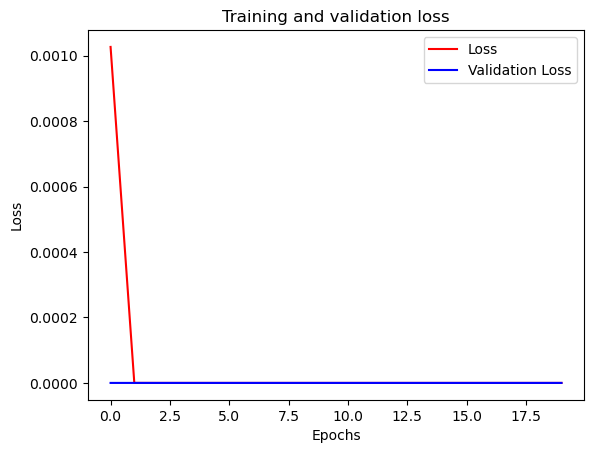

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()